In [ ]:
!mkdir "strs"

In [12]:

files = {
"virils":d1,
"willistoni": d2,
"yakuba": d3,
"simulans": d4,
"ananassae": d5,
"grimshawi":d6,
"mojavensis": d7,
"persimilis": d8,
"erecta": d9,
"sechellia": d10
}

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import os

if not torch.cuda.is_available():
  device = torch.device("cpu")
else:
  device = torch.device("cuda")

In [61]:
epochs = 600
batch_size = 5
lr = 0.01
total_length = 70000

In [16]:
class GenomicDataset(Dataset):
  def __init__(self, files):
    self.data = []
    for name, url in files.items():  #TODO: Redo this so that if it exists it will just grab the existing one.
      if not os.path.exists(f'/content/strs/{name}'):
        !wget -O "/content/strs/{name}" {url}
      with open(f'/content/strs/{name}') as f:
        for line in f:
          self.data.append(line)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    string = self.data[idx]
    j = np.random.randint(0, len(string) - total_length)
    x = string[j:j+total_length]
    x = [ord(c) for c in x]
    y = np.array(idx)
    x = np.array(x)
    return x, y

In [62]:
train_dataset = GenomicDataset(files)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [66]:
model = torch.nn.Sequential(
  torch.nn.Linear(total_length, 6000),
  torch.nn.Sigmoid(),
  torch.nn.Linear(6000, 2048),
  torch.nn.Sigmoid(),
  torch.nn.Linear(2048, 512),
  torch.nn.Sigmoid(),
  torch.nn.Linear(512, 256),
  torch.nn.Sigmoid(),
  torch.nn.Linear(256, 128),
  torch.nn.Sigmoid(),
  torch.nn.Linear(128, 64),
  torch.nn.Sigmoid(),
  torch.nn.Linear(64, 10)
)
model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [64]:
training_losses = []
training_accuracies = []


for epoch in range(epochs):
  for batch, (x, y_truth) in enumerate(train_loader):

    x = torch.tensor(x.clone().detach(), dtype=torch.float32).cuda()
    y_truth = torch.tensor(y_truth.clone().detach(), dtype=torch.long).cuda()

    y_pred = model(x)
    # print(y_pred)
    # print(y_truth)

    loss = criterion(y_pred, y_truth)
    optimizer.zero_grad()
    loss.backward()
    training_losses.append(loss.item())
    accuracy = (y_pred.argmax(1) == y_truth).float().mean()

    optimizer.step()

    if epoch % 5 == 0:
      training_accuracies.append(accuracy.item())


    if epoch % 40 == 0:
      print(f"Epoch {epoch} Batch {batch} Loss {loss.item()} Accuracy {accuracy.item()}")


<ipython-input-64-82845821a78f>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x.clone().detach(), dtype=torch.float32).cuda()
<ipython-input-64-82845821a78f>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_truth = torch.tensor(y_truth.clone().detach(), dtype=torch.long).cuda()


Epoch 0 Batch 0 Loss 2.1778149604797363 Accuracy 0.20000000298023224
Epoch 0 Batch 1 Loss 3.4002959728240967 Accuracy 0.0
Epoch 40 Batch 0 Loss 2.2863335609436035 Accuracy 0.20000000298023224
Epoch 40 Batch 1 Loss 2.3257269859313965 Accuracy 0.0
Epoch 80 Batch 0 Loss 2.3075733184814453 Accuracy 0.20000000298023224
Epoch 80 Batch 1 Loss 2.301384925842285 Accuracy 0.0
Epoch 120 Batch 0 Loss 2.305732250213623 Accuracy 0.20000000298023224
Epoch 120 Batch 1 Loss 2.3025975227355957 Accuracy 0.0
Epoch 160 Batch 0 Loss 2.304248809814453 Accuracy 0.0
Epoch 160 Batch 1 Loss 2.3030757904052734 Accuracy 0.20000000298023224
Epoch 200 Batch 0 Loss 2.3059449195861816 Accuracy 0.0
Epoch 200 Batch 1 Loss 2.3016390800476074 Accuracy 0.20000000298023224
Epoch 240 Batch 0 Loss 2.300410032272339 Accuracy 0.0
Epoch 240 Batch 1 Loss 2.3060545921325684 Accuracy 0.0
Epoch 280 Batch 0 Loss 2.3028130531311035 Accuracy 0.0
Epoch 280 Batch 1 Loss 2.303647756576538 Accuracy 0.0
Epoch 320 Batch 0 Loss 2.301739931106

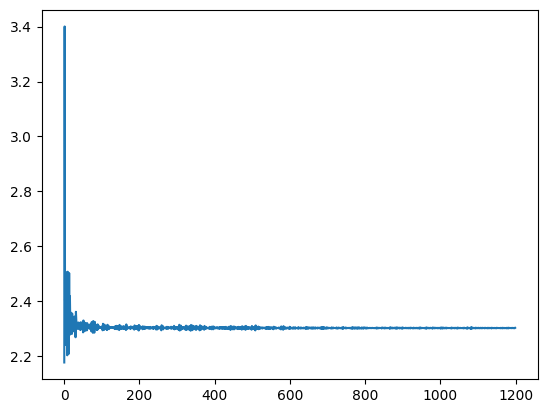

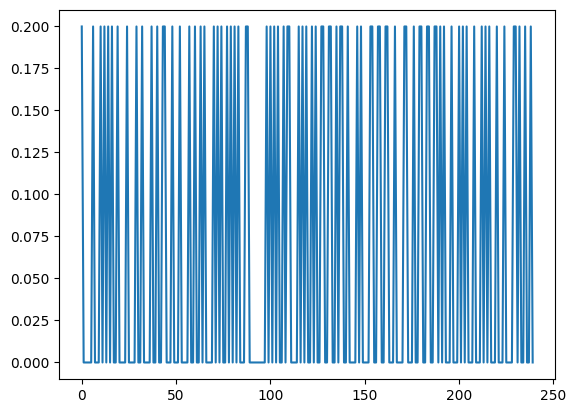

In [65]:
plt.plot(training_losses)
plt.show()

plt.plot(training_accuracies)
plt.show()

In [ ]:
class forward_model(nn.Module):
  def __init__(self):
    super(forward_model, self).__init__()
    self.lstm = nn.LSTM(total_length, total_length)
    self.fc = nn.Linear(total_length, total_length//2)
    self.gru = nn.GRU(total_length//2, 2)
    # self.down = nn.MaxPool2d(2)

  def forward(self, x):
    x, _ = self.lstm(x)
    print(x.shape)
    x = self.fc(x)
    print(x.shape)
    x = self.gru(x)[0]
    # print(x.shape)
    # x = self.down(x)
    # print(x.shape)
    return x
